<div class="head0">
    <div class="head0__name">
        Examples for func module
    </div>
    <div class="head0__note">
        Fast multidimensional function interpolation by Chebyshev polynomials in the dense (numpy) or sparse (tensor train (TT) with cross approximation) format using Fast Fourier Transform (FFT).
    </div>
</div>

In [1]:
import numpy as np

from fpcross import ij, Grid, Func

ij()

Start |  1:05PM MSK on Oct 11, 2019 | python 3.7.1    |
-------------------------------------------------------


<div class="head1">
    <div class="head1__name">
        Helper function
    </div>
    <div class="head1__note">
        For each interpolated function we presenting the following plots:
        <ol>
            <li>Computational times (for numpy and tensor-train formats), including "prep" for construction of tensor of the function values on the Chebyshev grid, "calc" for construction of interpolation coefficients and "comp" for computation of interpolant in one given spatial point.</li>
            <li>Interpolation error (for numpy and tensor-train formats) for the set of uniform random points scaled to the interpolation limits.</li>
            <li>Compression factor for the cross approximation and the tensor-train format, including function evaluations (v.s. total grid size) and compressed tensor size (v.s. total tensor size).</li>
        </ol>
    </div>
</div>

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

import tt

def func_check(N_tt, N_np, GR, func):
    from . import Func

    d = GR.d
    T_tt, E_tt, C_f_tt, C_a_tt = [], [], [], []
    T_np, E_np = [], []

    if N_np is not None:
        for n in N_np:
            GR.n = np.array([n]*d)
            FN = Func(GR)
            FN.init(func)
            FN.prep()
            FN.calc()
            FN.test()
            T_np.append(FN.tms.copy())
            E_np.append(np.mean(FN.err))

    if N_tt is not None:
        for n in (N_tt):
            GR.n = np.array([n]*d)
            FN = Func(GR, eps=1.E-6, with_tt=True)
            FN.init(func)
            FN.prep()
            FN.calc()
            FN.test()
            T_tt.append(FN.tms.copy())
            E_tt.append(np.mean(FN.err))
            c_f = FN.res['evals']
            for n in list(GR.n): c_f /= n
            C_f_tt.append(c_f)
            c_a = sum([G.size for G in tt.tensor.to_list(FN.A)])
            for n in list(GR.n): c_a /= n
            C_a_tt.append(c_a)
            
    fig = plt.figure(figsize=(12, 6))
    gs = mpl.gridspec.GridSpec(
        ncols=3, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
        wspace=0.3, hspace=0.01, width_ratios=[1, 1, 1], height_ratios=[1]
    )

    ax = fig.add_subplot(gs[0, 0])
    if N_tt is not None:
        ax.plot(
            N_tt, [T['prep'] for T in T_tt], label='Prep (TT)',
            color='blue', linewidth=3
        )
        ax.plot(
            N_tt, [T['calc'] for T in T_tt], label='Calc (TT)',
            color='green', linewidth=3
        )
        ax.plot(
            N_tt, [T['comp'] for T in T_tt], label='Comp (TT)',
            color='orange', linewidth=3
        )
    if N_np is not None:
        ax.plot(
            N_np, [T['prep'] for T in T_np], '-.', label='Prep (NP)',
            color='blue', linewidth=1, marker='*', markersize=5
        )
        ax.plot(
            N_np, [T['calc'] for T in T_np], '-.', label='Calc (NP)',
            color='green', linewidth=1, marker='*', markersize=5
        )
        ax.plot(
            N_np, [T['comp'] for T in T_np], '-.', label='Comp (NP)',
            color='orange', linewidth=1, marker='*', markersize=5
        )
    ax.set_title('Times (%d-dim)'%d)
    ax.semilogx()
    ax.semilogy()
    if N_tt is not None and N_np is not None: ax.legend(loc='best')

    ax = fig.add_subplot(gs[0, 1])
    if N_tt is not None:
        ax.plot(
            N_tt, E_tt, label='TT',
            color='black', linewidth=3
        )
    if N_np is not None:
        ax.plot(
            N_np, E_np, '-.', label='NP',
            color='black', linewidth=1, marker='*', markersize=5
        )
    ax.set_title('Interpolation error (%d-dim)'%d)
    ax.semilogx()
    ax.semilogy()
    if N_tt is not None and N_np is not None: ax.legend(loc='best')

    ax = fig.add_subplot(gs[0, 2])
    if N_tt is not None:
        ax.plot(
            N_tt, C_f_tt, label='Function evals',
            color='brown', linewidth=3
        )
        ax.plot(
            N_tt, C_a_tt, label='Tensor size',
            color='magenta', linewidth=3
        )
        ax.set_title('Compression (tt) factor (%d-dim)'%d)
        ax.semilogx()
        ax.semilogy()
        ax.legend(loc='best')

    plt.show()

<div class="head1">
    <div class="head1__name">
        Interpolation of 1-dimensional function
    </div>
    <div class="head1__note">
        Let consider 1D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x \right)}.
        $$
        Note that tensor-train format for 1D case works correct but not efficient since we cannot take advantage of the low-ranking representation of a multidimensional function.
    </div>
</div>

In [3]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ])

GR = Grid(d=1, n=[50], l=[[-3., 4.]])
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 1 
                 : Poi 50  | Min -3.000 | Max 4.000  |


In [4]:
FN = Func(GR)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 1D, NP
--> Time         | 
Prep             : 1.98e-04 sec. 
Calc             : 4.71e-03 sec. 
Comp (average)   : 4.52e-05 sec. 
Func (average)   : 3.92e-06 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 3.69e-14 
Error (mean)     : 3.35e-15 
Error (min)      : 0.00e+00 
-->Test (uni.gr.)|
Error (max)      : 9e-13   


In [5]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 1D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 1.09e-02 sec. 
Calc             : 3.57e-04 sec. 
Comp (average)   : 1.51e-05 sec. 
Func (average)   : 2.06e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 2.13e-13 
Error (mean)     : 4.46e-15 
Error (min)      : 0.00e+00 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:      200 
Cross iterations :        2 
Av. tt-rank      : 0.00e+00 
Cross err (rel)  : 0.00e+00 
Cross err (abs)  : 0.00e+00 
-->Test (uni.gr.)|
Error (max)      : 1e-12   


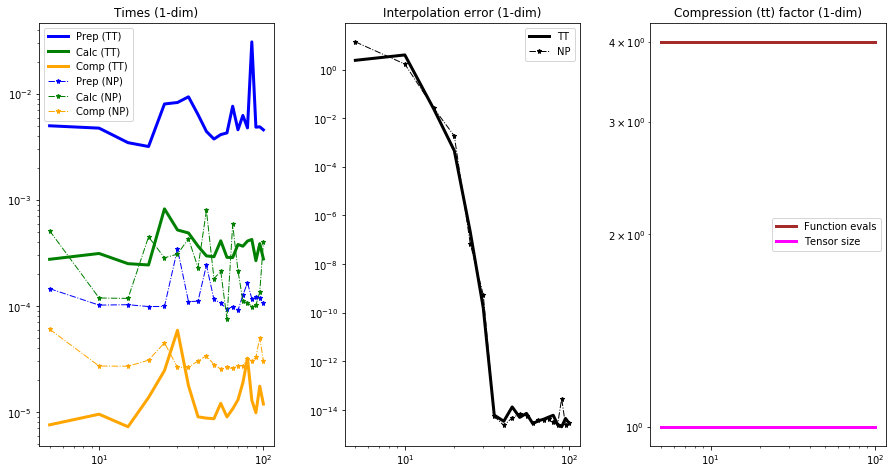

In [6]:
N_tt = np.arange(5, 101, 5)
N_np = np.arange(5, 101, 5)
func_check(N_tt, N_np, GR, func)

<div class="head1">
    <div class="head1__name">
        Interpolation of 2-dimensional function
    </div>
    <div class="head1__note">
        Let consider 2D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2}.
        $$
        Note that tensor-train format for 2D case works correct but not very efficient since we cannot take full advantage of the low-ranking representation of a multidimensional function.
    </div>
</div>

In [7]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ])

GR = Grid(d=2, n=[20, 24], l=[
    [-3., 4.],
    [-2., 3.],
])
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 2 
Mean             : Poi 22  | Min -2.500 | Max 3.500  |
Dim. # 1         : Poi 20  | Min -3.000 | Max 4.000  |
Dim. # 2         : Poi 24  | Min -2.000 | Max 3.000  |


In [8]:
FN = Func(GR)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 2D, NP
--> Time         | 
Prep             : 7.23e-04 sec. 
Calc             : 2.16e-03 sec. 
Comp (average)   : 7.95e-05 sec. 
Func (average)   : 1.50e-06 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 1.60e-02 
Error (mean)     : 4.44e-04 
Error (min)      : 4.12e-06 
-->Test (uni.gr.)|
Error (max)      : 7e-02   


In [9]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 2D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 2.06e-02 sec. 
Calc             : 6.83e-04 sec. 
Comp (average)   : 2.92e-05 sec. 
Func (average)   : 2.21e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 1.92e-03 
Error (mean)     : 2.29e-04 
Error (min)      : 1.25e-06 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:     1056 
Cross iterations :        3 
Av. tt-rank      : 7.00e+00 
Cross err (rel)  : 4.30e-16 
Cross err (abs)  : 3.10e-14 
-->Test (uni.gr.)|
Error (max)      : 7e-02   


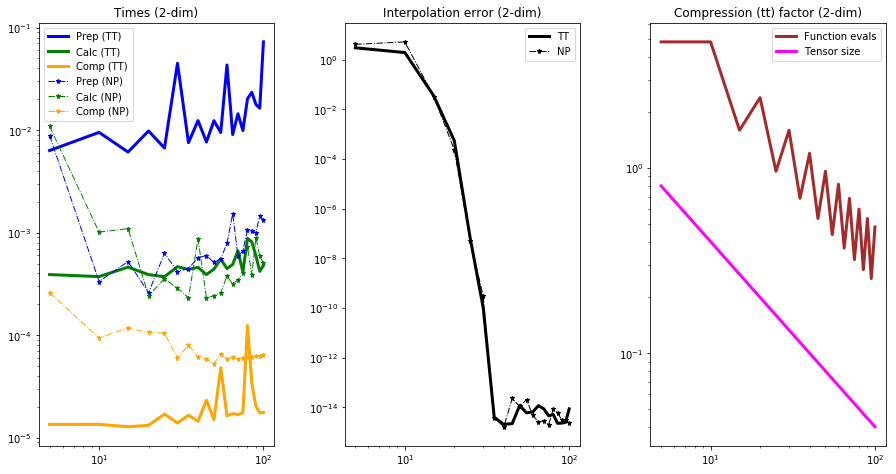

In [10]:
N_tt = np.arange(5, 101, 5)
N_np = np.arange(5, 101, 5)
func_check(N_tt, N_np, GR, func)

<div class="head1">
    <div class="head1__name">
        Interpolation of 3-dimensional function
    </div>
    <div class="head1__note">
        Let consider 3D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2} + \frac{x_3}{2}.
        $$
    </div>
</div>

In [11]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ]) + x[2, ] / 2.

GR = Grid(d=3, n=[20, 22, 24], l=[
    [-3., 4.],
    [-2., 3.],
    [-1., 1.],
])
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 3 
Mean             : Poi 22  | Min -2.000 | Max 2.667  |
Dim. # 1         : Poi 20  | Min -3.000 | Max 4.000  |
Dim. # 2         : Poi 22  | Min -2.000 | Max 3.000  |
Dim. # 3         : Poi 24  | Min -1.000 | Max 1.000  |


In [12]:
FN = Func(GR)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 3D, NP
--> Time         | 
Prep             : 5.49e-03 sec. 
Calc             : 1.69e-03 sec. 
Comp (average)   : 1.27e-04 sec. 
Func (average)   : 5.19e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 1.45e-02 
Error (mean)     : 5.37e-04 
Error (min)      : 1.45e-06 
-->Test (uni.gr.)|
Error (max)      : 4e-02   


In [13]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 3D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 7.98e-02 sec. 
Calc             : 8.79e-04 sec. 
Comp (average)   : 2.05e-05 sec. 
Func (average)   : 1.64e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 8.58e-03 
Error (mean)     : 5.17e-04 
Error (min)      : 6.03e-07 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:     3540 
Cross iterations :        3 
Av. tt-rank      : 7.50e+00 
Cross err (rel)  : 4.40e-16 
Cross err (abs)  : 1.50e-13 
-->Test (uni.gr.)|
Error (max)      : 4e-02   


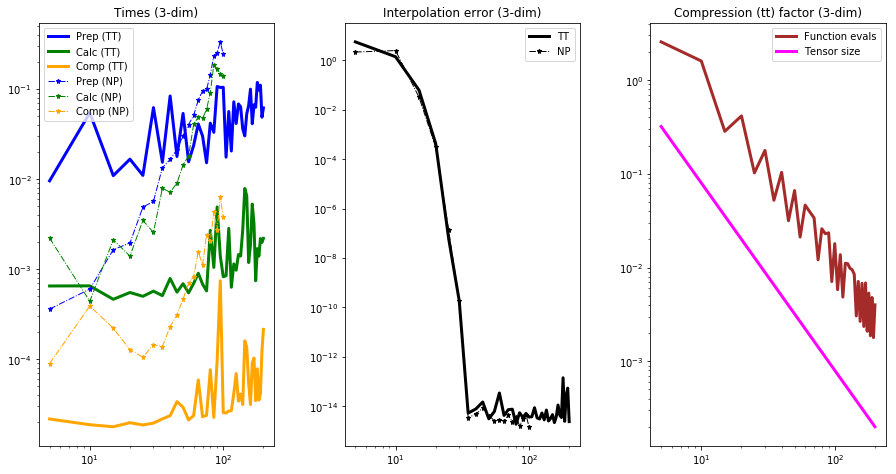

In [14]:
N_tt = np.arange(5, 201, 5)
N_np = np.arange(5, 101, 5)
func_check(N_tt, N_np, GR, func)

<div class="head1">
    <div class="head1__name">
        Interpolation of 4-dimensional function
    </div>
    <div class="head1__note">
        Let consider 4D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2} + \frac{x_3}{2} \cdot x_4^2.
        $$
    </div>
</div>

In [15]:
def func(x):
    return 2. * np.sin(np.pi * x[0, ]) + np.exp(-x[1, ]) + x[2, ] / 2. * x[3, ]**2

GR = Grid(d=4, n=[30, 31, 32, 33], l=[
    [-3., 4.],
    [-2., 3.],
    [-1., 1.],
    [-1., 3.],
])
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 4 
Mean             : Poi 31  | Min -1.750 | Max 2.750  |
Dim. # 1         : Poi 30  | Min -3.000 | Max 4.000  |
Dim. # 2         : Poi 31  | Min -2.000 | Max 3.000  |
Dim. # 3         : Poi 32  | Min -1.000 | Max 1.000  |
Dim. # 4         : Poi 33  | Min -1.000 | Max 3.000  |


In [16]:
FN = Func(GR)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 4D, NP
--> Time         | 
Prep             : 4.12e-01 sec. 
Calc             : 2.49e-01 sec. 
Comp (average)   : 5.96e-03 sec. 
Func (average)   : 4.20e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 5.68e-10 
Error (mean)     : 1.05e-10 
Error (min)      : 2.08e-14 
-->Test (uni.gr.)|
Error (max)      : 2e-10   


In [17]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

e = FN.test(n=1000, is_u=True)
print('-->Test (uni.gr.)|\nError (max)      : %-8.0e'%np.max(np.abs(e)))

------------------ Function
Format           : 4D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 1.24e-01 sec. 
Calc             : 9.25e-04 sec. 
Comp (average)   : 4.25e-05 sec. 
Func (average)   : 1.94e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 5.11e-08 
Error (mean)     : 6.28e-10 
Error (min)      : 3.61e-14 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:     8760 
Cross iterations :        3 
Av. tt-rank      : 7.30e+00 
Cross err (rel)  : 6.40e-16 
Cross err (abs)  : 2.30e-12 
-->Test (uni.gr.)|
Error (max)      : 2e-10   


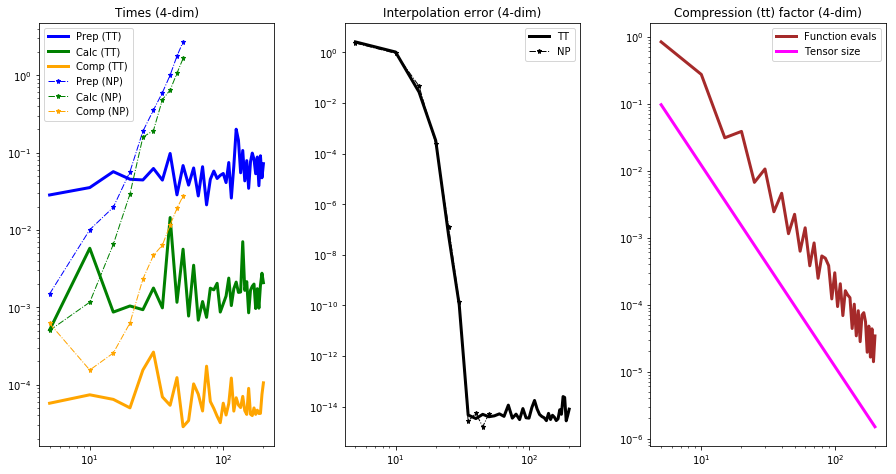

In [18]:
N_tt = np.arange(5, 201, 5)
N_np = np.arange(5, 51, 5)
func_check(N_tt, N_np, GR, func)

<div class="head1">
    <div class="head1__name">
        Interpolation of 5-dimensional function
    </div>
    <div class="head1__note">
        Let consider 5D function of the form
        $$
        f(x) = 2 \sin{\left( \pi x_1 \right)} + e^{-x_2} + \frac{x_3}{2} \cdot x_4^2 + 3 \cos{\left( \pi x_5^2 \right)}.
        $$
    </div>
</div>

In [19]:
def func(x):
    f = 2. * np.sin(np.pi * x[0, ])
    f+= np.exp(-x[1, ])
    f+= x[2, ] / 2. * x[3, ]**2
    f+= 3. * np.cos(np.pi * x[4, ]**2)
    return f

GR = Grid(d=5, n=[22, 24, 26, 28, 30], l=[
    [-3., 4.],
    [-2., 3.],
    [-1., 1.],
    [-1., 3.],
    [-6., 1.],
])
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 5 
Mean             : Poi 26  | Min -2.600 | Max 2.400  |
Dim. # 1         : Poi 22  | Min -3.000 | Max 4.000  |
Dim. # 2         : Poi 24  | Min -2.000 | Max 3.000  |
Dim. # 3         : Poi 26  | Min -1.000 | Max 1.000  |
Dim. # 4         : Poi 28  | Min -1.000 | Max 3.000  |
Dim. # 5         : Poi 30  | Min -6.000 | Max 1.000  |


In [20]:
FN = Func(GR)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=3**5)

------------------ Function
Format           : 5D, NP
--> Time         | 
Prep             : 1.83e+01 sec. 
Calc             : 6.68e+00 sec. 
Comp (average)   : 5.81e-02 sec. 
Func (average)   : 1.59e-06 sec. 
--> Test         | 
Number of points :      243 
Error (max)      : 5.73e+01 
Error (mean)     : 2.31e+00 
Error (min)      : 4.85e-05 


In [21]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

------------------ Function
Format           : 5D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 5.68e-02 sec. 
Calc             : 9.80e-04 sec. 
Comp (average)   : 3.48e-05 sec. 
Func (average)   : 1.83e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 7.48e+01 
Error (mean)     : 2.66e+00 
Error (min)      : 1.14e-03 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:     9984 
Cross iterations :        3 
Av. tt-rank      : 7.00e+00 
Cross err (rel)  : 7.80e-16 
Cross err (abs)  : 1.20e-11 


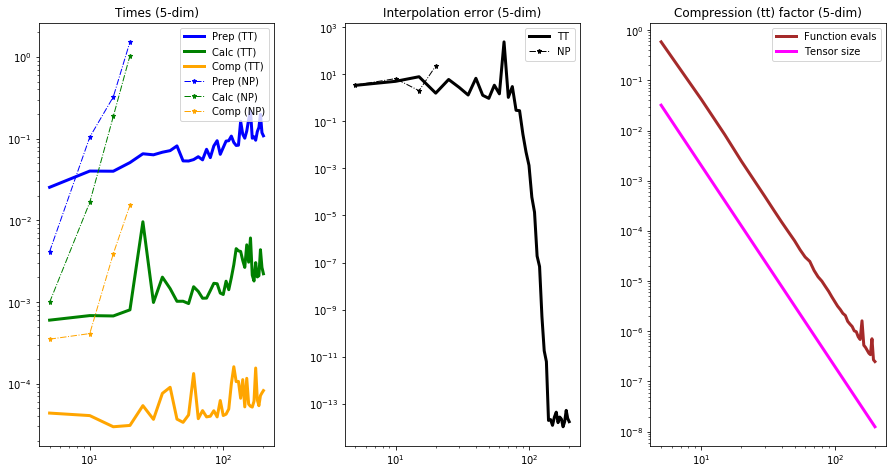

In [22]:
N_tt = np.arange(5, 201, 5)
N_np = np.arange(5, 21, 5)
func_check(N_tt, N_np, GR, func)

<div class="head1">
    <div class="head1__name">
        Interpolation of 10-dimensional function
    </div>
    <div class="head1__note">
        Let consider 10D function of the form
        $$
        f(x) = \sum_{k=1}^{10} \sin{\left( \frac{\pi}{k} x_k^2 \right)}.
        $$
        Note that only tensor-train format may be used in this case of multidimensional function.
    </div>
</div>

In [23]:
def func(x):
    f = 0.
    for k in range(d):
        f+= np.sin(np.pi / (k+1.) * x[k, ]**2)
    return f

d = 10
n = np.linspace(50, 70, d, dtype='int')
l = []
for k in range(d):
    l.append([-2. - k * 0.2, +2. + k * 0.2])
    
GR = Grid(d, n, l)
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 10
Mean             : Poi 59  | Min -2.900 | Max 2.900  |
Dim. # 1         : Poi 50  | Min -2.000 | Max 2.000  |
Dim. # 2         : Poi 52  | Min -2.200 | Max 2.200  |
Dim. # 3         : Poi 54  | Min -2.400 | Max 2.400  |
Dim. # 4         : Poi 56  | Min -2.600 | Max 2.600  |
Dim. # 5         : Poi 58  | Min -2.800 | Max 2.800  |
Dim. # 6         : Poi 61  | Min -3.000 | Max 3.000  |
Dim. # 7         : Poi 63  | Min -3.200 | Max 3.200  |
Dim. # 8         : Poi 65  | Min -3.400 | Max 3.400  |
Dim. # 9         : Poi 67  | Min -3.600 | Max 3.600  |
Dim. # 10        : Poi 70  | Min -3.800 | Max 3.800  |


In [24]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

------------------ Function
Format           : 10D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 1.86e-01 sec. 
Calc             : 2.60e-03 sec. 
Comp (average)   : 8.55e-05 sec. 
Func (average)   : 2.52e-07 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 1.16e-12 
Error (mean)     : 1.51e-13 
Error (min)      : 4.08e-15 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:    56996 
Cross iterations :        3 
Av. tt-rank      : 7.20e+00 
Cross err (rel)  : 2.00e-15 
Cross err (abs)  : 3.20e-06 


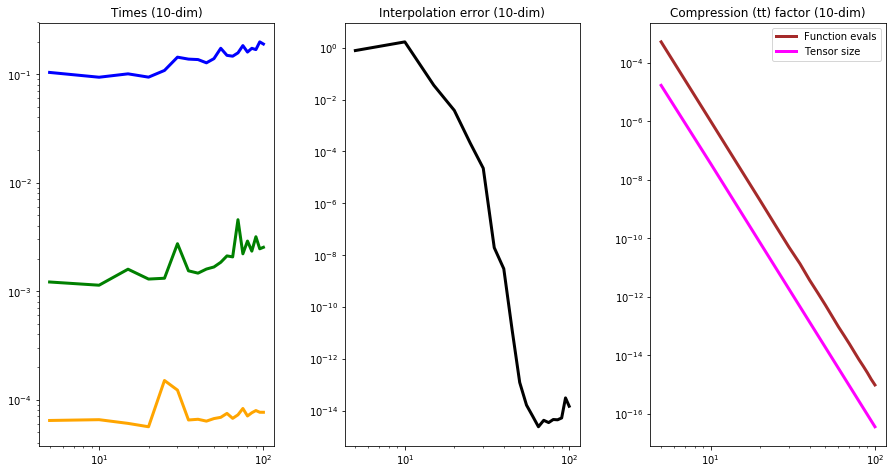

In [25]:
N_tt = np.arange(5, 101, 5)
N_np = None
func_check(N_tt, N_np, GR, func)

<div class="head2">
    <div class="head2__name">
        Interpolation of 99-dimensional function
    </div>
    <div class="head2__note">
        Let consider 99D function of the form
        $$
        f(x) = \sum_{k=1}^{99} \sin{\left( \frac{\pi}{k} x_k^2 \right)}.
        $$
        Note that only tensor-train format may be used in this case of multidimensional function.
    </div>
</div>

In [26]:
def func(x):
    f = 0.
    for k in range(d):
        f+= np.sin(np.pi / (k+1.) * x[k, ]**2)
    return f

d = 99
n = np.linspace(20, 40, d, dtype='int')
l = []
for k in range(d):
    l.append([-2. - k * 0.01, +2. + k * 0.015])

GR = Grid(d, n, l)
GR.info()

------------------ Grid
Kind             : Chebyshev
Dimensions       : 99
Mean             : Poi 29  | Min -2.490 | Max 2.735  |
Dim. # 1         : Poi 20  | Min -2.000 | Max 2.000  |
Dim. # 2         : Poi 20  | Min -2.010 | Max 2.015  |
Dim. # 3         : Poi 20  | Min -2.020 | Max 2.030  |
Dim. # 4         : Poi 20  | Min -2.030 | Max 2.045  |
Dim. # 5         : Poi 20  | Min -2.040 | Max 2.060  |
 ...             : ...
Dim. # 95        : Poi 39  | Min -2.940 | Max 3.410  |
Dim. # 96        : Poi 39  | Min -2.950 | Max 3.425  |
Dim. # 97        : Poi 39  | Min -2.960 | Max 3.440  |
Dim. # 98        : Poi 39  | Min -2.970 | Max 3.455  |
Dim. # 99        : Poi 40  | Min -2.980 | Max 3.470  |


In [27]:
FN = Func(GR, eps=1.E-6, with_tt=True)
FN.init(func)
FN.prep()
FN.calc()
FN.info(n_test=100)

------------------ Function
Format           : 99D, TT, eps= 1.00e-06
--> Time         | 
Prep             : 3.47e+00 sec. 
Calc             : 9.81e-02 sec. 
Comp (average)   : 7.08e-04 sec. 
Func (average)   : 1.96e-06 sec. 
--> Test         | 
Number of points :      100 
Error (max)      : 7.84e-04 
Error (mean)     : 3.08e-04 
Error (min)      : 3.26e-06 
--> Cross params | 
nswp             :      200 
kickrank         :        1 
rf               : 2.00e+00 
--> Cross result | 
Func. evaluations:   351273 
Cross iterations :        3 
Av. tt-rank      : 8.00e+00 
Cross err (rel)  : 2.00e-15 
Cross err (abs)  : 1.20e+59 


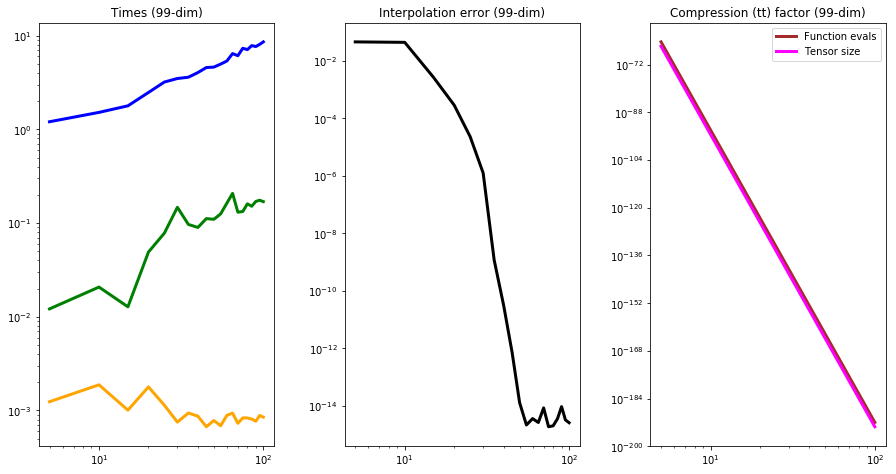

In [28]:
N_tt = np.arange(5, 101, 5)
N_np = None
func_check(N_tt, N_np, GR, func)

<div class="end"></div>

<div class="head1">
    <div class="head1__name">
        TMP (DRAFT)
    </div>
</div>

<div class="head1">
    <div class="head1__name">
        Direct construction of 1D Chebyshev interpolation
    </div>
</div>

<div class="head2">
    <div class="head2__name">
        Direct construction of 1D Chebyshev interpolation for one function
    </div>
</div>

Max relative error for interpolation points : 1.33e-15
Max relative error for random points        : 8.36e-16


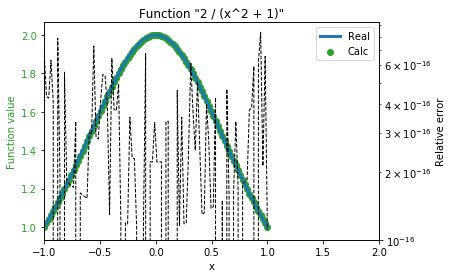

In [10]:
from fpcross import polynomials_cheb

def func_f(x):
    return 2. / (x**2 + 1.)

n = 200
N = n - 1
j = np.arange(n)
x = np.cos(np.pi * j / N)
u = func_f(x)
a = Func.interpolate_cheb(u)

u = u.reshape(-1, 1)
v = polynomials_cheb(x, N).T@a
e = np.abs((v - u) / u)
print('Max relative error for interpolation points : %-8.2e'%np.max(e))

x = np.linspace(-1., 1., 100)
u = func_f(x).reshape(-1, 1)
v = polynomials_cheb(x, N).T@a
e = np.abs((v - u) / u)
print('Max relative error for random points        : %-8.2e'%np.max(e))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.set_title('Function "2 / (x^2 + 1)"')
ax1.set_xlabel('x')
ax1.set_xlim(-1, 2)

ax1.set_ylabel('Function value', color='tab:green')
ax1.plot(x, u, color='tab:blue', linewidth=3, label='Real')
ax1.scatter(x, v, color='tab:green', label='Calc')
ax1.tick_params(axis='y', which='both', labelcolor='tab:green')
ax1.legend(loc='best')

ax2.set_ylabel('Relative error', color='black')
ax2.plot(x, e, '--', linewidth=1, color='black')
ax2.tick_params(axis='y', which='both', labelcolor='black')
ax2.semilogy()

plt.show()

<div class="head2">
    <div class="head2__name">
        Direct construction of 1D Chebyshev interpolation for several functions
    </div>
</div>

Max relative error for random points : 8.36e-16 | Func: 2 / (x^2 + 1)
Max relative error for random points : 8.72e-16 | Func: e^{x^2/4}
Max relative error for random points : 1.40e-15 | Func: sin(\pi * x^2) + 2 / (x + 2)
Max relative error for random points : 9.14e-14 | Func: cos(\pi * x^3) - 2 / x^2


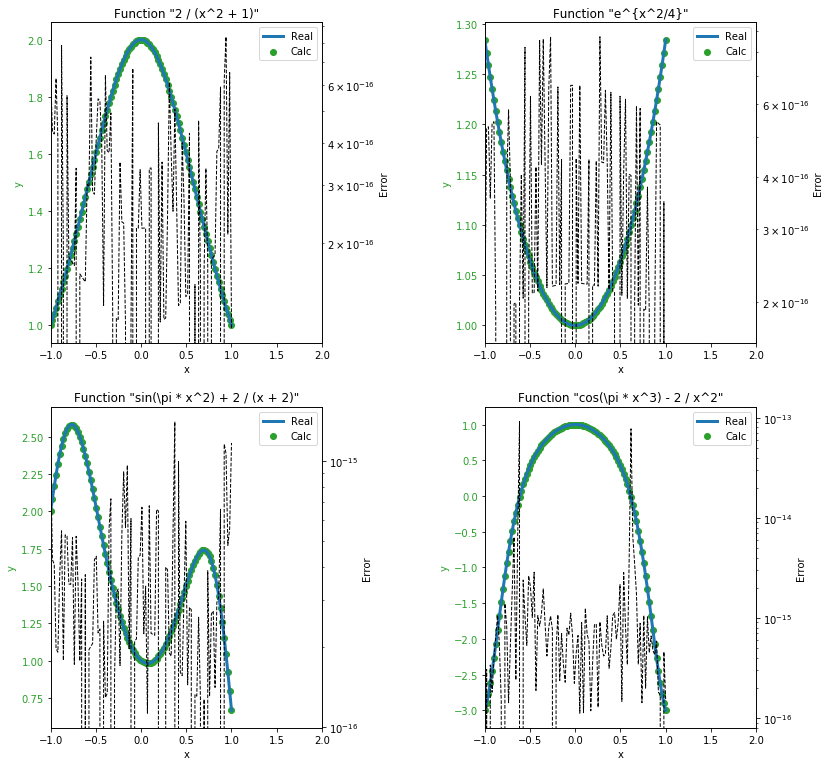

In [11]:
def func_f1(x): return 2. / (x**2 + 1.)
def func_f2(x): return np.exp(x**2 / 4.)
def func_f3(x): return np.sin(np.pi * x**2) + 2. / (x + 2.)
def func_f4(x): return np.cos(np.pi * x**3) - 2. * x**2

funcs = [
    '2 / (x^2 + 1)',
    'e^{x^2/4}',
    'sin(\pi * x^2) + 2 / (x + 2)',
    'cos(\pi * x^3) - 2 / x^2',
]

n = 200
N = n - 1
j = np.arange(n)
x = np.cos(np.pi * j / N)
u1 = func_f1(x).reshape(-1, 1)
u2 = func_f2(x).reshape(-1, 1)
u3 = func_f3(x).reshape(-1, 1)
u4 = func_f4(x).reshape(-1, 1)
a = Func.interpolate_cheb(np.hstack([u1, u2, u3, u4]))

fig = plt.figure(figsize=(10, 10))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.6, hspace=0.2, width_ratios=[1, 1], height_ratios=[1, 1]
)

x = np.linspace(-1., 1., 100)

for k in range(len(funcs)):
    i = int(k / 2)
    j = k - 2*i
    
    u = eval('func_f%d'%(k+1))(x)
    v = polynomials_cheb(x, N).T@a[:, k]
    e = np.abs((v - u) / u)
    
    print('Max relative error for random points : %-8.2e | Func: %s'%(np.max(e), funcs[k]))

    ax1 = fig.add_subplot(gs[i, j])
    ax2 = ax1.twinx()
    
    ax1.set_title('Function "%s"'%funcs[k])
    ax1.set_xlabel('x')
    ax1.set_xlim(-1, 2)

    ax1.set_ylabel('y', color='tab:green')
    ax1.plot(x, u, color='tab:blue', linewidth=3, label='Real')
    ax1.scatter(x, v, color='tab:green', label='Calc')
    ax1.tick_params(axis='y', which='both', labelcolor='tab:green')
    ax1.legend(loc='best')

    ax2.set_ylabel('Error', color='black')
    ax2.plot(x, e, '--', linewidth=1, color='black')
    ax2.tick_params(axis='y', which='both', labelcolor='black')
    ax2.semilogy()

plt.show()

<div class="head2">
    <div class="head2__name">
        Complexity estimation of 1D Chebyshev interpolation for several functions
    </div>
</div>

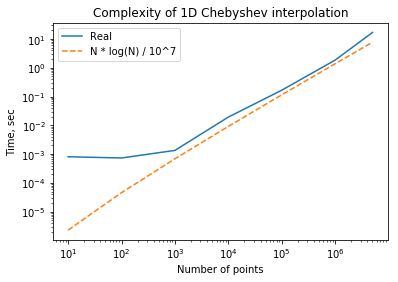

In [12]:
def func_f(x):
    return np.exp(x**2 / 4.)

k = 10
N = np.array([1E1, 1E2, 1E3, 1E4, 1E5, 1E6, 5E6])
T = np.array([])

for n in N:
    j = np.arange(n)
    x = np.cos(np.pi * j / (n-1))
    u = func_f(x).reshape(-1, 1)
    t = time.time()
    a = Func.interpolate_cheb(np.repeat(u, k, axis=1))
    T = np.append(T, [time.time()-t])

C = N * np.log(N) / 1.0E7

plt.plot(N, T, label='Real')
plt.plot(N, C, '--', label='N * log(N) / 10^7')
plt.title('Complexity of 1D Chebyshev interpolation')
plt.xlabel('Number of points')
plt.ylabel('Time, sec')
plt.semilogx()
plt.semilogy()
plt.legend(loc='best')
plt.show()

<div class="head1">
    <div class="head1__name">
        Test for the cross approximation in the TT-format
    </div>
</div>

In [19]:
def f(x):
    return 1. + x[0, ] ** 1 + x[1, ] ** 2 + x[2, ] ** 3

def f_pois(i):
    return i

n = [5, 6, 7]
eps = 1.E-6
opts = {
    'nswp': 2,
}

Y, crs_res = Intertrain.cross(f, f_pois, n, eps, opts, './tmp.txt')
Y = Y.full()

I = np.array([
    [1, 2, 3, 4],
    [2, 1, 0, 3],
    [3, 2, 1, 0]
])
y_real = f(f_pois(I))
y_calc = np.array([Y[tuple(I[:, k])] for k in range(I.shape[1])])
err = np.abs((y_real - y_calc) / y_real)

print('Result: ', crs_res)
print('Errors: ', ', '.join(['%8.2e'%e for e in err]))

Result:  {'evals': 384, 't_func': 7.382283608118693e-07, 'iters': 2, 'err_rel': 2.3e-15, 'err_abs': 3.6e-12, 'erank': 5.0}
Errors:  0.00e+00, 2.96e-16, 0.00e+00, 2.54e-16
